Adapted from [SpeechBrain](https://speechbrain.github.io/) Tutorials

## **1. Fourier Transform**


In [ ]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav
!pip install speechbrain

In [ ]:
import torch
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio

signal = read_audio('spk1_snt1.wav')
print(signal.shape)

# fft computation
fft = torch.fft.fft(signal.squeeze(), dim=0)
print(fft)
print(fft.shape)

torch.Size([45920])
tensor([-0.0114+0.0000j, -0.0088-0.0205j, -0.0261+0.0205j,  ...,
         0.0340-0.0350j, -0.0261-0.0205j, -0.0088+0.0205j])
torch.Size([45920])


While the input signal is real (note that imaginary part is filled with zeros), the Discrete Fourier Transform (DFT) is a tensor containing both the real and the imaginary parts of the transformation. Below we compute the magnitude and phase of the DFT and plot them:

Text(0.5, 0, 'Freq [Hz]')

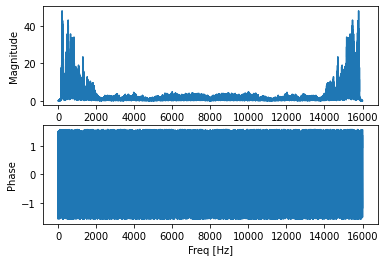

In [ ]:
# Real and Imaginary parts
real_fft = fft.real
img_fft = fft.imag

mag = torch.sqrt(torch.pow(real_fft,2) + torch.pow(img_fft,2))
phase = torch.arctan(img_fft/real_fft)

plt.subplot(211)
x_axis = torch.linspace(0, 16000, mag.shape[0])
plt.plot(x_axis, mag)
plt.ylabel('Magnitude')

plt.subplot(212)
plt.plot(x_axis, phase)
plt.ylabel('Phase')
plt.xlabel('Freq [Hz]')




*   The magnitude plot is symmetric around the middle frequency value (Nyquist frequency)
*   The phase plot is quite noisy



Text(0.5, 0, 'Freq [Hz]')

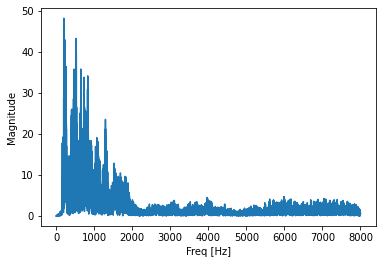

In [ ]:
half_point = mag[0:].shape[0]//2
x_axis = torch.linspace(0, 8000, half_point)
plt.plot(x_axis, mag[0:half_point])
plt.ylabel('Magnitude')
plt.xlabel('Freq [Hz]')

When plotting the magnitude upto Nyquist frequency, we can see that most of the energy of a speech signal is concentrated in the lower part of the spectrum. Many important phonemes like vowels, in fact, have most of their energy in this part of the spectrum.

Text(0.5, 0, 'Freq [Hz]')

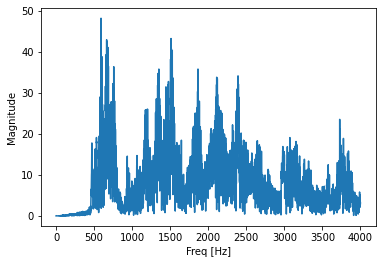

In [ ]:
plt.plot(mag[0:4000])
plt.ylabel('Magnitude')
plt.xlabel('Freq [Hz]')

By further zooming in, we see the peaks that corresponds to pitch (i.e, the frequency at which our vocal cords are vibrating) and formats (which corresponds to the resonant frequency of our vocal tract).

/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:958: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


tensor([-9.1553e-05, -9.1553e-05, -9.1553e-05, -6.1035e-05, -6.1035e-05,
        -6.1035e-05, -6.1035e-05, -6.1035e-05, -9.1553e-05, -6.1035e-05])
tensor([-9.1551e-05+4.9844e-10j, -9.1550e-05-1.3959e-11j,
        -9.1554e-05+1.5200e-09j, -6.1035e-05-1.7612e-09j,
        -6.1036e-05+2.2479e-09j, -6.1038e-05-1.1457e-09j,
        -6.1035e-05+9.5556e-10j, -6.1034e-05+2.8955e-09j,
        -9.1553e-05-2.5375e-09j, -6.1033e-05+1.4067e-09j])


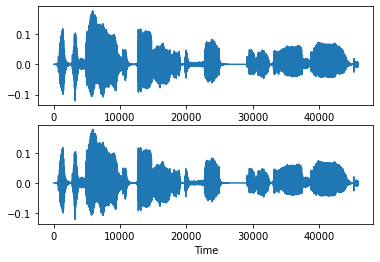

In [ ]:
signal_rec = torch.fft.ifft(fft, dim=0)
signal_rec = signal_rec # real part
signal_orig = signal

# Plots
plt.subplot(211)
plt.plot(signal_orig)

plt.subplot(212)
plt.plot(signal_rec)
plt.xlabel('Time')

print(signal_orig[0:10])
print(signal_rec[0:10])

While the signal can be recunstructed in the time domai, due to some numerical round-off errros, the reconstructed signal is not identical to the original.

## **2. Short-Term Fourier Transform (STFT)**
Speech is a "dynamic" signal that evolves over time. It could thus make sense to introduce a mixed time-frequency representation that can show how the frequency components of speech are evolving over time. Such a representation is called Short-Term Fourier Transform.

The SFTF is computed in this way:

1. Split the time signal into multiple chunks using overlapped sliding windows (e.g, hamming, hanning, blackman).
2. For each small chunk compute the DFT
3. Combine all the DFT into a single representation

Let's now compute an STFT of a speech signal:

In [ ]:
from speechbrain.processing.features import STFT

signal = read_audio('spk1_snt1.wav').unsqueeze(0) # [batch, time]

compute_STFT = STFT(sample_rate=16000, win_length=25, hop_length=10, n_fft=400) # 25 ms, 10 ms
signal_STFT = compute_STFT(signal)

print(signal.shape)
print(signal_STFT.shape)

torch.Size([1, 45920])
torch.Size([1, 288, 201, 2])


*   The first dimension of the STFT representation is the batch axis (SpeechBrain expects it because it is designed to process in parallel multiple signals).
* The third is the frequency resolution. It corresponds to half of the fft points ($n_{fft}$) because, as we have seen before, the fft is symmetric.
* The last dimension gathers the real and the imaginary parts of the STFT representation.

Similar to the Fourier transform, the STFT has an inverse transformation called **Inverse Short-Term Fourier Transform (ISTFT)**. With properly-designed windows,  we can have a perfect reconstruction of the original signal:

Text(0.5, 0, 'Time')

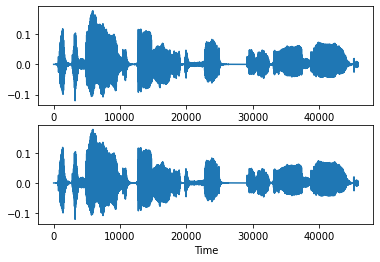

In [ ]:
from speechbrain.processing.features import ISTFT

compute_ISTFT = ISTFT(sample_rate=16000, win_length=25, hop_length=10)
signal_rec = compute_ISTFT(signal_STFT)
signal_rec = signal_rec.squeeze() # remove batch axis for plotting

# Plots
plt.subplot(211)
plt.plot(signal_orig)

plt.subplot(212)
plt.plot(signal_rec)
plt.xlabel('Time')

## **3. Spectrogram**
As we have seen before, the magnitude of the Fourier transform is more informative than the phase. We can thus take the magnitude of the STFT representation and obtain the so-called spectrogram. The spectrogram is one of the most popular speech representations.

Let's see how a spectrogram looks like:

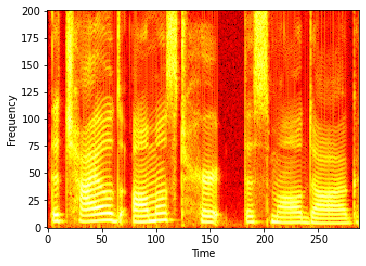

In [ ]:
spectrogram = signal_STFT.pow(2).sum(-1) # power spectrogram
spectrogram = spectrogram.squeeze(0).transpose(0,1)

spectrogram_log = torch.log(spectrogram) # for graphical convenience

plt.imshow(spectrogram_log.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


The spectrogram is a 2D representation that can be plotted as an image (yellow areas correspond to time-frequency points with high magnitude).
From the spectrogram, you can see how the frequency components are evolving over time. For instance, you can clearly distinguish vowels (whose frequency pattern is characterized by multiple lines corresponding to pitch and formants)  and fricatives (characterized by the presence of continuous high-frequency components). Normally, we plot the power spectrogram that corresponds to the squared magnitude of the STFT.

The time and frequency resolution of the spectrogram depends on the length of the window used for computing the STFT.

For instance, if we increase the length of the window, we can have a higher resolution in frequency (but a lower resolution in time):


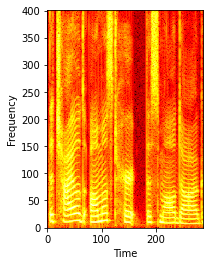

In [ ]:
signal = read_audio('spk1_snt1.wav').unsqueeze(0) # [batch, time]

compute_STFT = STFT(sample_rate=16000, win_length=50, hop_length=10, n_fft=800)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1)
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


Vice-versa, we can have a larger time resolution at the price of a reduced frequency resolution:

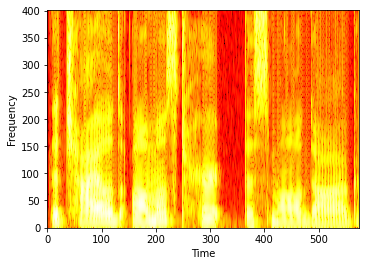

In [ ]:
signal = read_audio('spk1_snt1.wav').unsqueeze(0) # [batch, time]

compute_STFT = STFT(sample_rate=16000, win_length=5, hop_length=5, n_fft=800)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1)
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

Despite being very informative, the spectrogram is not invertible. When computing it, in fact, we are only using the magnitude of the STFT and not the phase.

The spectrogram is the starting point for computing some popular speech features, such ad FilterBanks (FBANKs) and Mel-Frequency Cepstral Coefficients (MFCCs)

## **4. Filter Banks (FBANKs)**
FBANKs are time-frequency representations computed by applying a **set of filters** to the spectrogram of a speech signal. Please, [take a look at this tutorial](https://colab.research.google.com/drive/1dCY2XHC6NiDA9mor3jd9H9w-XEcD3M4L?usp=sharing) for a detailed overview on Fourier transform and spectrograms.

First of all, let's download some speech signals and install SpeechBrain:

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav
!pip install speechbrain

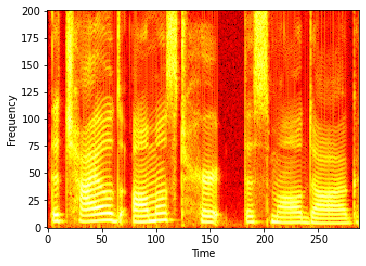

In [ ]:
import torch
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT

signal = read_audio('spk1_snt1.wav').unsqueeze(0) # [batch, time]

compute_STFT = STFT(sample_rate=16000, win_length=25, hop_length=10, n_fft=400)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1) # Power spectrogram
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

One way to compress the signal is to average the spectrogram over the frequency axis. This is done with a set of filters:

From the spectrogram, we can notice that most of the energy is concentrated in the **lower part of the spectrum**. It is convenient to allocate more filters in the lower part of the spectrum and fewer filters for high-frequency components.  This is what the mel filter banks are doing.

Each filter is **triangular** and has a response of 1 at the center frequency. The response decreases linearly towards 0 till it reaches the center frequencies of the two adjacent filters (see figure). There is thus some **overlap** between adjacent filters.

The filters are designed to be equally-spaced in the mel-frequency domain. It is possible to pass from the linear frequency domain to the mel one (and vice-versa) with the following non-linear transformations:

$ m=2595log10(1+f/700)$

$f=700(10m/2595−1)$,

where $m$ is the mel frequency component and $f$ the standard frequency one (in Hz). The mel-frequency domain is compressed with a logarithm. The result is that filters equally spaced in the mel-domain will not be equally spaced in the target linear domain. We indeed have more filters in the lower part of the spectrum and less in the higher as desired.

Let's now compute FBANKs using SpeechBrain:

torch.Size([1, 288, 201, 2])
torch.Size([1, 288, 201])
torch.Size([1, 288, 40])


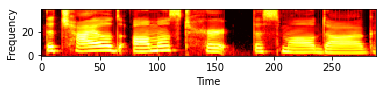

In [ ]:
from speechbrain.processing.features import spectral_magnitude
from speechbrain.processing.features import Filterbank

compute_fbanks = Filterbank(n_mels=40)

STFT = compute_STFT(signal)
mag = spectral_magnitude(STFT)
fbanks = compute_fbanks(mag)

print(STFT.shape)
print(mag.shape)
print(fbanks.shape)

plt.imshow(fbanks.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


Normally, 40 or 80 FBANKs are computed. As you can observe from the shapes, the dimensionality of the time axis is the same. The dimensionality of the frequency axis, instead, has been reduced. You can see FBANKs just as a simple way to **compress** the rich information embedded in the spectrogram.

The SpeechBrain implementation of the filterbanks is designed to support different shapes of the filters (triangular, rectangular, gaussian). Moreover, when freeze=False, the filters are not frozen and can be tuned during training.

To make it easier the computation of FBANKs, we created a lobe that performs all the needed steps in a single function:

The SpeechBrain implementation of the filterbanks is designed to support different shapes for the filters (triangular, rectangular, gaussian). Morever, when `freeze=False`, the filters are not frozen and can be tuned during training.

To make it easier the computation of FBANKs, we created a lobe that performs all the needed steps in a single functions:



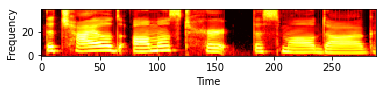

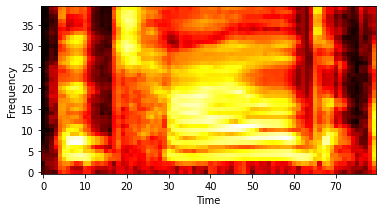

In [ ]:
from speechbrain.lobes.features import Fbank
fbank_maker = Fbank()
fbanks = fbank_maker(signal)

plt.imshow(fbanks.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Zoom of first 80 steps
plt.imshow(fbanks.squeeze(0).t()[:,0:80], cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## **2. Mel-Frequency Cepstral Coefficients (MFCCs)**
MFCCs are computed by applying a Discrete Cosine Transform (DCT) on the top of the FBANKs. The DCT is a transformation that decorrelates the features and can be used to further compress them.

To make the computation of MFCCs easier, we created a lobe for that:


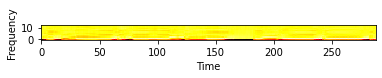

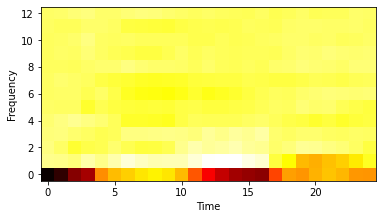

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, deltas=False, context=False)
mfccs = mfcc_maker(signal)

plt.imshow(mfccs.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#Zoom of the first 25 steps
plt.imshow(mfccs.squeeze(0).t()[:,0:25], cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In the past, working on decorrelated features was essential. Past machine learning techniques such as Gaussian Mixture Model (GMMS) were not suitable to model correlated data. Deep Neural networks, instead, can be work very well also with **correlated data** and FBANKs are nowadays the preferred choice.


## **3. Context Information**
Proper management of local context is essential to most speech processing tasks. The dominant solution in the past was about setting a “hand-crafted” context with the following approaches:

*   Derivatives  
*   Context windows

### 3.1 Derivatives
The idea behind derivatives is to introduce a local context by simply computing the **difference** with adjacent features. The derivatives are often computed with MFCCS coefficients:

torch.Size([1, 288, 13])
torch.Size([1, 288, 39])


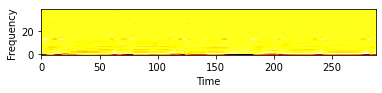

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, deltas=True, context=False)
mfccs_with_deltas = mfcc_maker(signal)

print(mfccs.shape)
print(mfccs_with_deltas.shape)

plt.imshow(mfccs_with_deltas.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


The first and second-order derivatives are called delta and delta-delta coefficients and are concatenated with the static coefficients. In the examples, the dimensionality is thus 39 (13 statics, 13 deltas, 13 delta-deltas).

### 3.2 Context Windows
Context windows adds a local context by simply **concatenating** multiple consecutive features. The result is a bigger feature vector that is better "aware" of the local information.

Let's see an example:

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13,
                  deltas=True,
                  context=True,
                  left_frames=5,
                  right_frames=5)
mfccs_with_context = mfcc_maker(signal)

print(mfccs.shape)
print(mfccs_with_deltas.shape)
print(mfccs_with_context.shape)

torch.Size([1, 288, 13])
torch.Size([1, 288, 39])
torch.Size([1, 288, 429])


In this case, we concatenate the current frame with 5 past and 5 future frames. The total dimesionality is thus $39 * (5+5+1)= 429$

Instead of using the aforementioned solutions, the current trend is to use static features and progressively add a **learnable context** through the **receptive field** on a **Convolutional Neural Network** (CNN). CNNs are often used in the early layers of the neural speech processing system to derive robust and context-aware representations.